# FASE PERSIAPAN: SETUP DAN PEMUATAN DATA

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [13]:
# Konfigurasi tampilan
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
# Menggunakan plot inline
%matplotlib inline

In [14]:
# --- 1. Memuat Data ---
# Memuat file 'Online_Retail_Clean.csv'
try:
    df_clean = pd.read_csv('Online_Retail_Clean.csv')
    print("Data berhasil dimuat.")
    print(f"Jumlah baris awal: {len(df_clean)}")
except FileNotFoundError:
    print("Error: File 'Online_Retail_Clean.csv' tidak ditemukan.")
    # Exit atau tambahkan dummy data jika diperlukan untuk testing
    exit()

Data berhasil dimuat.
Jumlah baris awal: 338151


# FASE FEATURE ENGINEERING & MODELLING (SPRINT 2)

In [15]:
## 2.1. Penciptaan Fitur Non-RFM Kunci per Pelanggan

print("Mulai Feature Engineering Non-RFM...")

# Membuat fitur tambahan di level transaksi (ItemsPerInvoice)
item_features = df_clean.groupby('InvoiceNo')['StockCode'].nunique().reset_index()
item_features.rename(columns={'StockCode': 'ItemsPerInvoice'}, inplace=True)
df_clean = pd.merge(df_clean, item_features, on='InvoiceNo', how='left')


# Aggregasi data ke level CustomerID
customer_features = df_clean.groupby('CustomerID').agg(
    # Fitur 1: Total Quantity Dibeli
    TotalQuantityDibeli=('Quantity', 'sum'),

    # Fitur 2: Total Pengeluaran (Pengganti Moneter)
    TotalPengeluaran=('TotalPrice', 'sum'),

    # Fitur 3: Jumlah Transaksi (Pengganti Frekuensi)
    JumlahTransaksi=('InvoiceNo', 'nunique'),

    # Fitur 4: Rata-rata Nilai Transaksi (Avg Order Value)
    RataRataNilaiTransaksi=('TotalPrice', 'mean'),

    # Fitur 5: Jumlah Kategori/Item Unik yang Dibeli
    JumlahItemUnik=('StockCode', 'nunique'),

    # Fitur 6: Rata-rata Items per Invoice (Variasi Belanja per Transaksi)
    RataRataItemPerInvoice=('ItemsPerInvoice', 'mean'),
).reset_index()

# Fitur Tambahan: Rata-rata Pengeluaran per Item
customer_features['AvgPengeluaranPerItem'] = customer_features['TotalPengeluaran'] / customer_features['JumlahItemUnik']

# Pilih fitur yang akan digunakan untuk clustering
features_to_cluster = [
    'TotalQuantityDibeli',
    'TotalPengeluaran',
    'JumlahTransaksi',
    'RataRataNilaiTransaksi',
    'JumlahItemUnik',
    'RataRataItemPerInvoice',
    'AvgPengeluaranPerItem'
]

X = customer_features[features_to_cluster].copy()

# Penanganan Nilai Abnormal (Infiniti atau NaN yang mungkin muncul dari pembagian)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

print(f"Jumlah baris setelah feature engineering dan penanganan NaN: {len(X)}")

Mulai Feature Engineering Non-RFM...
Jumlah baris setelah feature engineering dan penanganan NaN: 4191


In [16]:
## 2.2. Scaling Data: Normalisasi menggunakan StandardScaler

print("Mulai Scaling Data menggunakan StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=features_to_cluster)

# Tampilkan 5 baris pertama dari data yang sudah di-scale
print("\n--- Hasil Kerja Sprint 2: Data Scaled (Head) ---")
print(df_scaled.head())

Mulai Scaling Data menggunakan StandardScaler...

--- Hasil Kerja Sprint 2: Data Scaled (Head) ---
   TotalQuantityDibeli  TotalPengeluaran  JumlahTransaksi  \
0             1.024171          1.035788         0.425524   
1            -0.367887         -0.426386        -0.144653   
2            -0.063747         -0.014220        -0.429742   
3            -0.323418         -0.333791        -0.429742   
4            -0.082011          0.045541         0.425524   

   RataRataNilaiTransaksi  JumlahItemUnik  RataRataItemPerInvoice  \
0                0.274980        0.532549                0.209621   
1               -0.149702       -0.645601               -0.938075   
2                0.039054        0.035108                1.636487   
3                0.140022       -0.514696               -0.329542   
4                0.031199       -0.082707               -0.572104   

   AvgPengeluaranPerItem  
0               0.691450  
1              -0.294977  
2              -0.183994  
3          

In [17]:
## 2.3. Implementasi Clustering Awal (K-Means - Penyiapan)
# Implementasi K-Means yang sebenarnya (pemilihan K) akan dilakukan di Sprint 3,
# tetapi persiapan data scaled ini adalah hasil utama Sprint 2.
print("\nModel K-Means Awal siap untuk dievaluasi di Sprint 3.")


Model K-Means Awal siap untuk dievaluasi di Sprint 3.


# FASE EVALUASI & PROFILING (SPRINT 3)

Mulai Evaluasi Model (Menentukan K Optimal)...


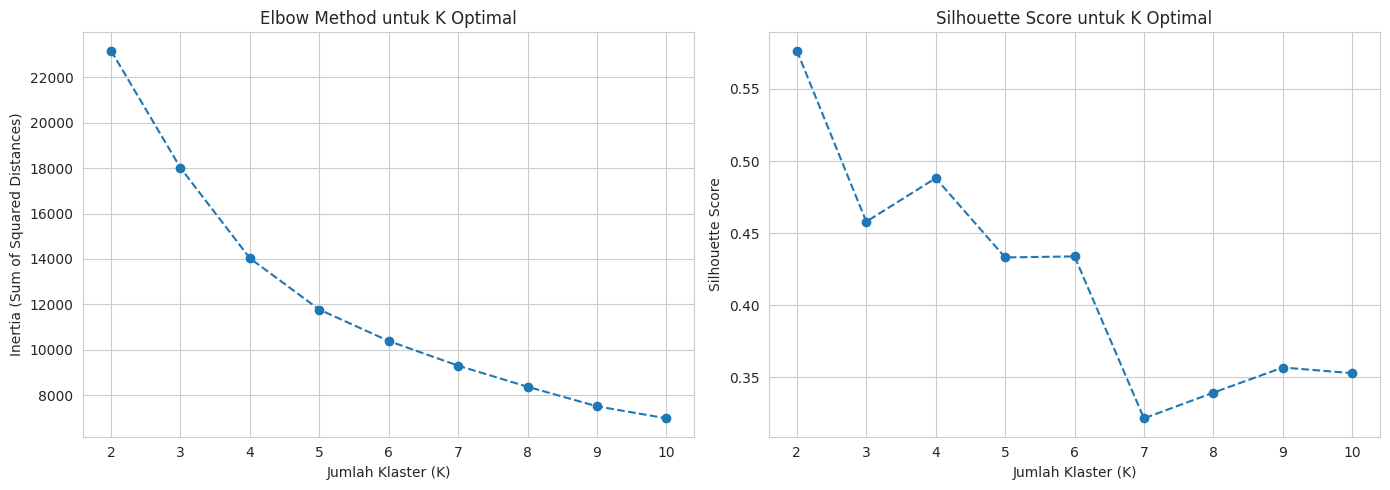

In [18]:
## 3.1. Evaluasi Model: Penentuan K Optimal
print("Mulai Evaluasi Model (Menentukan K Optimal)...")

# Inisialisasi list untuk Elbow Method dan Silhouette Score
inertia = []
silhouette_scores = []
K_range = range(2, 11) # Coba K dari 2 sampai 10

for k in K_range:
    # Membangun dan melatih model K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Kriteria: Inertia (Elbow Method)
    inertia.append(kmeans.inertia_)

    # Kriteria: Silhouette Score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Visualisasi Elbow Method dan Silhouette Score
plt.figure(figsize=(14, 5))

# Plot Elbow Method
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method untuk K Optimal')
plt.xlabel('Jumlah Klaster (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(K_range)

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score untuk K Optimal')
plt.xlabel('Jumlah Klaster (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)

plt.tight_layout()
plt.show()

In [19]:
# Menentukan K optimal (misalnya K=4, berdasarkan visualisasi yang umum)
optimal_k = 4
print(f"Keputusan: Berdasarkan evaluasi visual, K optimal dipilih = {optimal_k}")

Keputusan: Berdasarkan evaluasi visual, K optimal dipilih = 4


In [20]:
## 3.2. Implementasi Klaster Akhir

print(f"\nMelatih Model K-Means Akhir dengan K = {optimal_k}...")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

# Tambahkan label klaster ke DataFrame X (data fitur)
X['Cluster'] = kmeans_final.labels_

# Gabungkan label klaster ke DataFrame utama pelanggan
customer_id_with_cluster = pd.DataFrame(X.index, columns=['OriginalIndex'])
customer_id_with_cluster['CustomerID'] = customer_features.loc[X.index, 'CustomerID'].values
customer_id_with_cluster['Cluster'] = X['Cluster'].values

customer_features = pd.merge(customer_features, customer_id_with_cluster[['CustomerID', 'Cluster']], on='CustomerID', how='inner')


Melatih Model K-Means Akhir dengan K = 4...


In [21]:
## 3.3. Analisis Klaster: Membuat Profil Segmen Pelanggan

print("Mulai Analisis Karakteristik Statistik Setiap Klaster...")

# Hitung statistik rata-rata (mean) dari fitur Non-RFM per klaster
cluster_profile = customer_features.groupby('Cluster')[features_to_cluster].mean().reset_index()

print("\n--- Ringkasan Profil Klaster (Rata-rata Fitur Non-RFM) ---")
print(cluster_profile.round(2))

Mulai Analisis Karakteristik Statistik Setiap Klaster...

--- Ringkasan Profil Klaster (Rata-rata Fitur Non-RFM) ---
   Cluster  TotalQuantityDibeli  TotalPengeluaran  JumlahTransaksi  \
0        0               617.21           1633.03             7.22   
1        1               323.71            534.66             2.58   
2        2              1641.14           2685.88             8.35   
3        3             20567.00          36183.63           105.71   

   RataRataNilaiTransaksi  JumlahItemUnik  RataRataItemPerInvoice  \
0                   49.54           22.13                    6.81   
1                   15.56           31.95                   17.72   
2                   11.50          160.28                   51.11   
3                   13.42          992.43                   93.09   

   AvgPengeluaranPerItem  
0                  77.49  
1                  17.48  
2                  17.22  
3                  39.32  


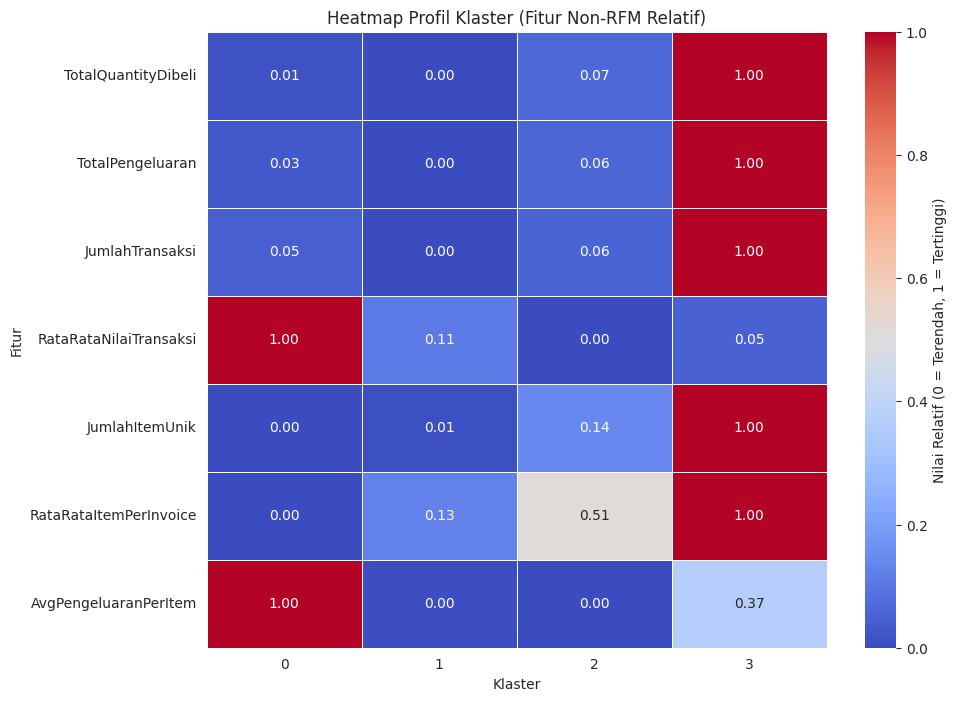

In [22]:
## 3.4. Visualisasi Profil Klaster (untuk Wawasan Bisnis)

# Scaling data profil klaster untuk visualisasi perbandingan (min-max scaling sederhana)
cluster_profile_scaled = cluster_profile.set_index('Cluster').copy()
cluster_profile_scaled = cluster_profile_scaled.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Visualisasi Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_profile_scaled.T, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={'label': 'Nilai Relatif (0 = Terendah, 1 = Tertinggi)'})
plt.title('Heatmap Profil Klaster (Fitur Non-RFM Relatif)')
plt.ylabel('Fitur')
plt.xlabel('Klaster')
plt.show()